In [1]:
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import torch
from dataset.datasets import get_dataset
from settings import TrainingSettings, AnnotationSettings, AudioProcessingSettings, CNNSettings
from model.cnn import CNN
from dataclasses import asdict
from torch import optim
from main import train_epoch, evaluate

ColorSequenceRegistry; available colormaps:
'tab10', 'tab20', 'tab20b', 'tab20c', 'Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3'


Text(0.5, 1.0, 'Precision-Recall curve')

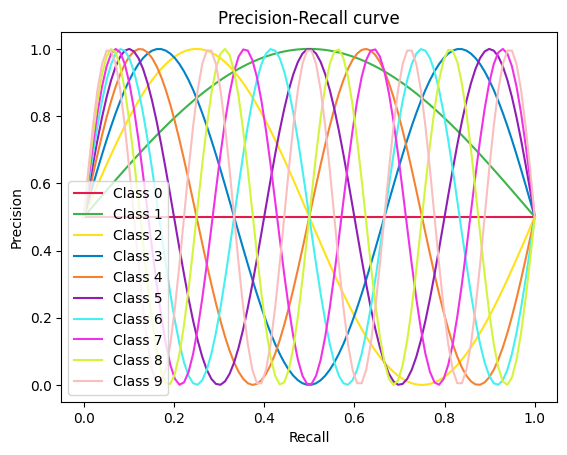

In [2]:
from matplotlib.colors import ListedColormap
from matplotlib import color_sequences

print(color_sequences)

colors = np.array([
        [230, 25, 75],
        [60, 180, 75],
        [255, 225, 25],
        [0, 130, 200],
        [245, 130, 48],
        [145, 30, 180],
        [70, 240, 240],
        [240, 50, 230],
        [210, 245, 60],
        [250, 190, 190],
        [0, 128, 128],
        [230, 190, 255],
        [170, 110, 40],
        [255, 250, 200],
        [128, 0, 0],
        [170, 255, 195],
        [128, 128, 0],
        [255, 215, 180],
        [0, 0, 128],
        [128, 128, 128],
        [0, 0, 0],
    ]) / 255
colormap = ListedColormap(colors, N=21)

# Plot a pseudo pr curve
for i in range(10):
    x = np.linspace(0, 1, 100)
    y = np.sin(x * np.pi * i) * 0.5 + 0.5
    plt.plot(x, y, color=colors[i], label=f"Class {i}")
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")

In [2]:
training_settings: TrainingSettings = TrainingSettings(epochs=30, scheduler=False, num_workers=16)
audio_settings: AudioProcessingSettings = AudioProcessingSettings()
annotation_settings: AnnotationSettings = AnnotationSettings()
cnn_settings = CNNSettings(
        n_classes=annotation_settings.n_classes, n_mels=audio_settings.n_mels
)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

In [13]:
loader_train, loader_val, loader_test_rbma, loader_test_mdb = get_dataset(
    training_settings, audio_settings, annotation_settings
)

KeyboardInterrupt: 

In [4]:
model = CNN(**asdict(cnn_settings))
model.to(device)

CNN(
  (conv1): ResidualBlock(
    (conv1): CausalConv2d(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 2), bias=False)
    )
    (conv2): CausalConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 2), bias=False)
    )
    (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ELU(alpha=1.0)
    (re_sample): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (pool1): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2): ResidualBlock(
    (conv1): CausalConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 2), bias=False)
    )
    (conv2): CausalConv2d(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 2), bias=False)
    )
    (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [5]:
max_lr = training_settings.learning_rate
initial_lr = max_lr / 25
_min_lr = initial_lr / 1e4
initial_lr = (
    training_settings.learning_rate
    if not training_settings.scheduler
    else initial_lr
)
optimizer = optim.RAdam(
    model.parameters(), lr=initial_lr, weight_decay=1e-5
)
scheduler = (
    optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=max_lr,
        steps_per_epoch=len(loader_train),
        epochs=training_settings.epochs,
    )
    if training_settings.scheduler
    else None
)
error = torch.nn.BCEWithLogitsLoss(reduction="none")
scaler = torch.cuda.amp.GradScaler()

In [62]:
model.to(device)
best_loss = float("inf")
best_score = 0
last_improvement = 0
for epoch in range(10):
    train_loss = train_epoch(
        epoch,
        loader_train,
        device,
        None,
        error,
        model,
        optimizer,
        scaler,
        scheduler,
        tensorboard_writer=None,
    )
    val_loss, f_score, avg_f_score = evaluate(
        epoch,
        model,
        loader_val,
        error,
        device,
        training_settings.ignore_beats,
        tensorboard_writer=None,
        tag="Validation",
    )
    print(
        f"Epoch: {epoch + 1} "
        f"Loss: {train_loss * 100:.4f}\t "
        f"Val Loss: {val_loss * 100:.4f} F-Score: {avg_f_score * 100:.4f}/{f_score * 100:.4f}"
    )

Evaluation: 100%|██████████| 154/154 [00:15<00:00,  9.79mini-batch/s]


Epoch: 1 Loss: 20.4206	 Val Loss: 19.3332 F-Score: 4.2299/5.3949


Evaluation: 100%|██████████| 154/154 [00:15<00:00,  9.98mini-batch/s]


Epoch: 2 Loss: 20.4206	 Val Loss: 19.3332 F-Score: 4.2299/5.3949


Evaluation: 100%|██████████| 154/154 [00:15<00:00,  9.78mini-batch/s]


Epoch: 3 Loss: 20.4205	 Val Loss: 19.3332 F-Score: 4.2299/5.3949


Evaluation: 100%|██████████| 154/154 [00:15<00:00,  9.92mini-batch/s]


Epoch: 4 Loss: 20.4205	 Val Loss: 19.3332 F-Score: 4.2299/5.3949


Evaluation: 100%|██████████| 154/154 [00:16<00:00,  9.48mini-batch/s]


Epoch: 5 Loss: 20.4196	 Val Loss: 19.3322 F-Score: 26.2726/18.2078


Evaluation: 100%|██████████| 154/154 [00:17<00:00,  8.71mini-batch/s]


Epoch: 6 Loss: 20.4052	 Val Loss: 19.3071 F-Score: 56.3722/56.1446


Evaluation: 100%|██████████| 154/154 [00:18<00:00,  8.45mini-batch/s]


Epoch: 7 Loss: 20.3084	 Val Loss: 19.3728 F-Score: 64.5343/61.9424


Evaluation: 100%|██████████| 154/154 [00:17<00:00,  8.93mini-batch/s]


Epoch: 8 Loss: 20.2529	 Val Loss: 19.3550 F-Score: 65.3614/62.4957


Evaluation: 100%|██████████| 154/154 [00:17<00:00,  8.95mini-batch/s]


Epoch: 9 Loss: 20.2258	 Val Loss: 19.3665 F-Score: 66.2036/63.5674


Evaluation: 100%|██████████| 154/154 [00:18<00:00,  8.50mini-batch/s]


Epoch: 10 Loss: 20.2015	 Val Loss: 19.3062 F-Score: 66.8244/64.4339


In [65]:
torch.cuda.empty_cache()
model.cpu()
loader = iter(loader_test_rbma)

In [66]:
spec, target, annotation = next(loader)
model.eval()
with torch.no_grad():
    output = model(spec)

In [67]:
print(output.shape)
print(target.shape)
print(spec.shape)

torch.Size([1, 3, 23884])
torch.Size([1, 3, 23884])
torch.Size([1, 82, 23884])


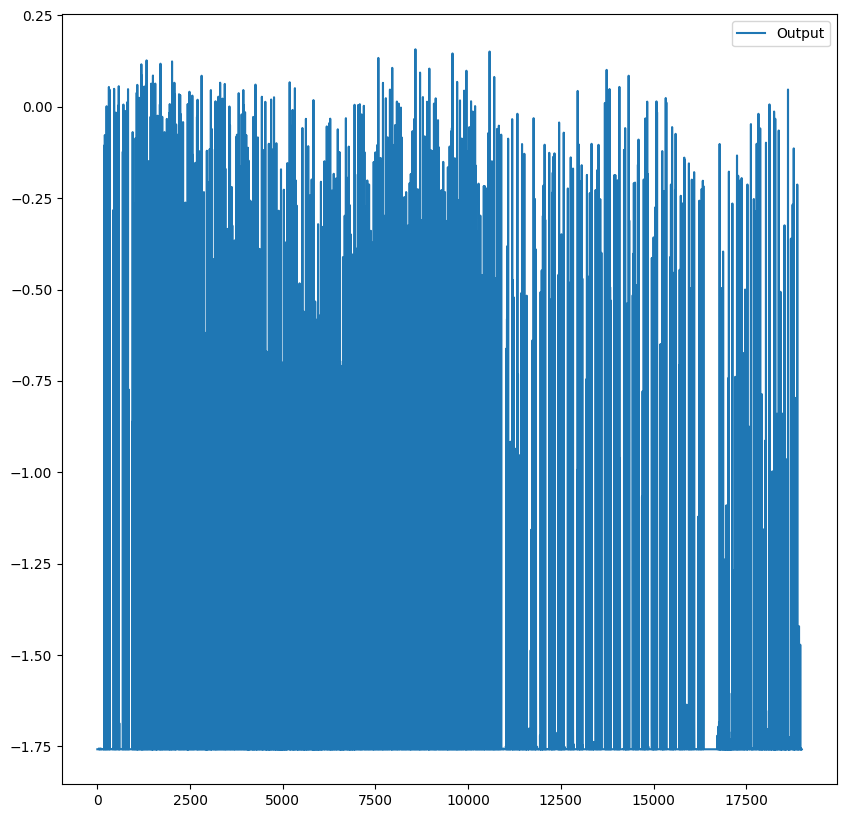

In [68]:
section = range(1000, 20000)
plt.figure(figsize=(10, 10))
plt.plot(output[0][0][section].numpy(), label="Output")
plt.legend()
plt.show()

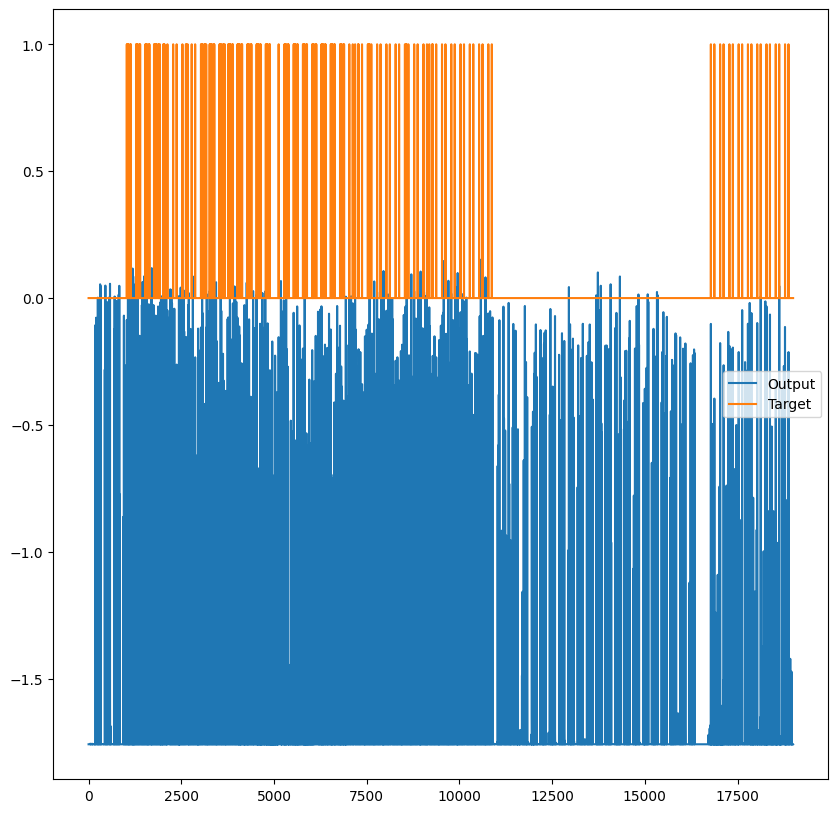

In [69]:
section = range(1000, 20000)
plt.figure(figsize=(10, 10))
plt.plot(output[0][0][section].numpy(), label="Output")
plt.plot(target[0][0][section].numpy(), label="Target")
plt.legend()
plt.show()

tensor([671])
tensor(0.3301)
tensor(0.3301)
tensor(-0.5918)
tensor(5.5419)


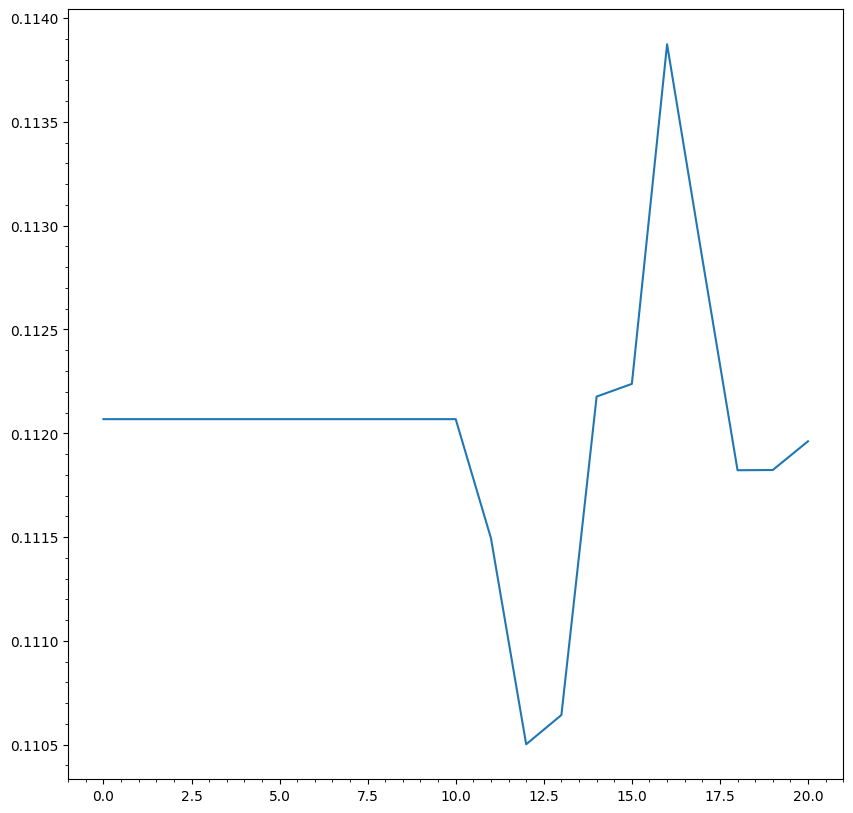

In [138]:
from model import CausalConv2d, ResidualBlock, ResidualBlock1d

eps = np.nextafter(np.float16(0.0), np.float16(1.0))
class_idx = 2
offset = 1
first_label = target[0][class_idx].nonzero()[15]
print(first_label)

causal_test = spec.clone()
causal_test[0, :, :first_label+offset] = 0
# causal_test[0, :, first_label+offset+30:] = 0
empty_model = ResidualBlock1d(1, 1, kernel_size=5)


model.eval()
with torch.no_grad():
    # output = model(causal_test)
    empty_output = empty_model(causal_test.unsqueeze(1)).squeeze(1)

output = empty_output

    
print(torch.min(output[0, class_idx, first_label-offset-40:first_label+offset]))
print(torch.max(output[0, class_idx, first_label-offset-40:first_label+offset]))
print(torch.min(output[0, class_idx, first_label+offset:]))
print(torch.max(output[0, class_idx, first_label+offset:]))

plt.figure(figsize=(10, 10))
plt.plot(output[0][0][first_label+offset-10-1:first_label+offset+10].numpy(), label="Output")
plt.minorticks_on()

In [3]:
import nnAudio.features
from dataset.RBMA13 import RBMA_13
from dataset import load_audio
import torchaudio
import librosa

In [4]:
rbma = RBMA_13(
    root="./data/rbma_13",
    audio_settings=audio_settings,
    annotation_settings=annotation_settings,
    use_dataloader=False,
    is_train=False,
)

In [5]:
mel_log, labels, gt = rbma[2]
test_audio = load_audio(rbma.get_full_path("RBMA-13-Track-03"), audio_settings.sample_rate, audio_settings.normalize)
gt = gt[2:]

torch.Size([84, 21531])


torch.Size([84, 21531])

In [6]:
cqt = nnAudio.features.CQT1992v2(
    sr=audio_settings.sample_rate,
    hop_length=audio_settings.hop_size,
    fmin=20,
    fmax=20000, 
    bins_per_octave=12,
    pad_mode=audio_settings.pad_mode,
)

stft = torchaudio.transforms.Spectrogram(
    n_fft=audio_settings.fft_size,
    hop_length=audio_settings.hop_size,
    win_length=audio_settings.fft_size // 2,
    power=2,
    center=audio_settings.center,
    pad_mode=audio_settings.pad_mode,
    normalized=True,
    onesided=True,
)

mel = torchaudio.transforms.MelScale(
    n_mels=audio_settings.n_mels,
    sample_rate=audio_settings.sample_rate,
    f_min=audio_settings.mel_min,
    f_max=audio_settings.mel_max,
    n_stft=audio_settings.fft_size // 2 + 1,
)

CQT kernels created, time used = 0.0526 seconds


/home/marclie/.virtualenvs/Automatic Drum Transcription/lib/python3.11/site-packages/nnAudio/utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)


In [31]:
cqt_spec = cqt(test_audio)[0]
stft_spec = stft(test_audio)
mel_spec = mel(stft_spec)
print(cqt_spec.shape)
print(mel_spec.shape)

torch.Size([120, 21535])
torch.Size([84, 21531])


[array([0.24975, 0.72594, 1.20213, 1.67832]), array([], dtype=float64), array([], dtype=float64)]


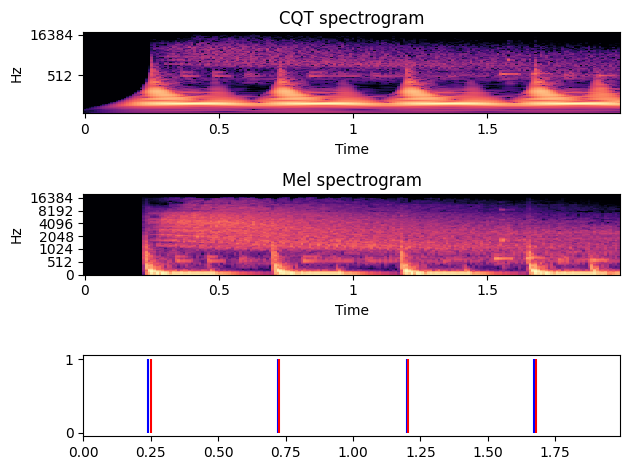

In [40]:
plot_range = slice(000, 200)

gt_labels = [np.array([label - plot_range.start / 100 for label in cls if plot_range.start <= int(label * 100) <= plot_range.stop]) for cls in gt]
print(gt_labels)

db = librosa.amplitude_to_db(cqt_spec[:, plot_range], ref=np.max)
fig, ax = plt.subplots(nrows=3)
img = librosa.display.specshow(
    db, 
    y_axis='cqt_hz', 
    x_axis='time', 
    ax=ax[0], 
    sr=audio_settings.sample_rate, 
    hop_length=audio_settings.hop_size,
    fmin=20,
    fmax=20000,
)
ax[0].set(title='CQT spectrogram')

M = mel_spec[:, plot_range].detach().numpy()
M_db = librosa.power_to_db(M, ref=np.max)
img = librosa.display.specshow(
    M_db,
    y_axis='mel', 
    x_axis='time',
    ax=ax[1], 
    sr=audio_settings.sample_rate, 
    hop_length=audio_settings.hop_size, 
    fmin=audio_settings.mel_min, 
    fmax=audio_settings.mel_max
)
ax[1].set(title='Mel spectrogram')

time = np.array([np.array(range(labels[:, plot_range].shape[1])) / 100] * 3).T

ax[0].vlines(time[labels[:, plot_range].T == 1], ymin=0, ymax=1)
ax[1].vlines(time[labels[:, plot_range].T == 1], ymin=0, ymax=1)
ax[2].vlines(time[labels[:, plot_range].T == 1], ymin=0, ymax=1, colors=["blue"])
for cls in gt_labels:
    ax[2].vlines(cls, ymin=0, ymax=1, colors=["red"])
ax[2].set_xlim(left=0, right=time[-1][0])
plt.tight_layout()